In [1]:
import math
import matplotlib.pyplot as plt
import gprsim
import numpy as np

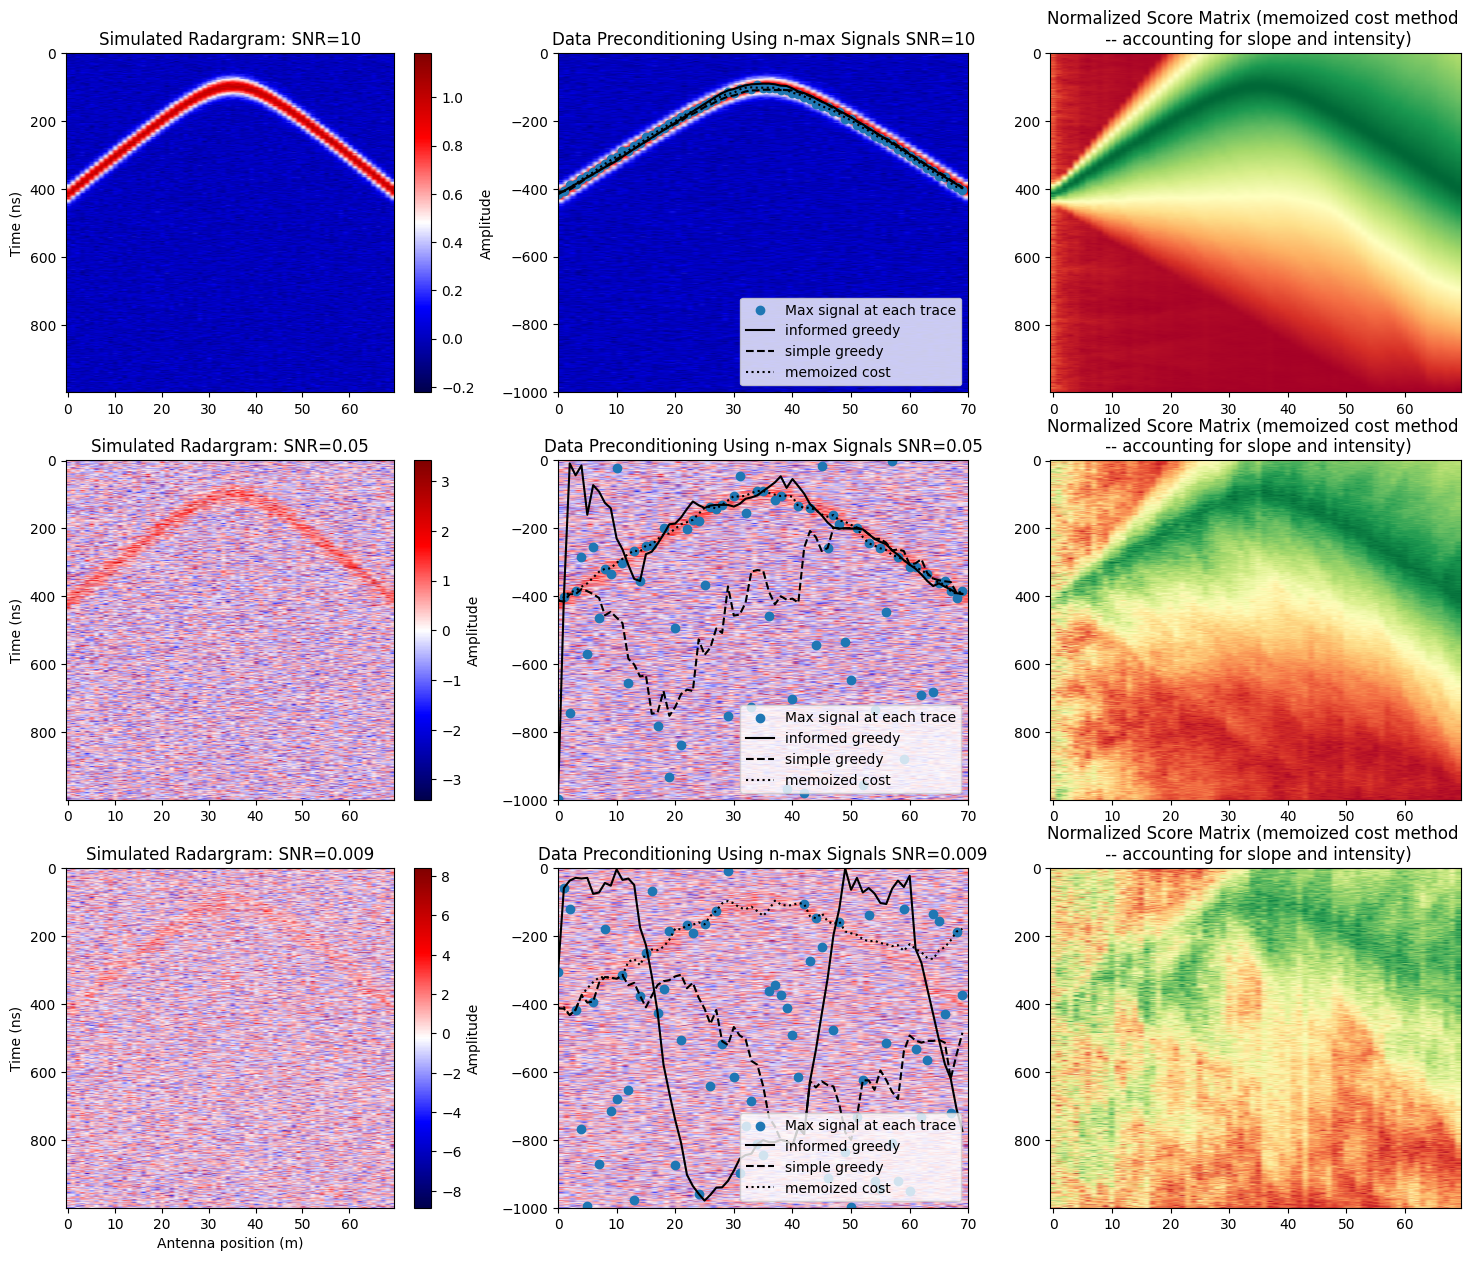

In [362]:
def visualize_preconditioning():
    fig, ax = plt.subplots(3, 3, figsize=(18,15))
    
    for SNR, i in zip([10, 0.05, 0.009], range(0,3)):
        # Parameters
        eps_r = 3                  # relative dielectric permittivity
        rf = 40e6                 # radar frequency different from pulse frequency
        dt = 1e-9                  # seconds
        dx = 1                     # meters
        region_shape = (70, 1e-6)  # grid (x,z)
        wavetype = 'gaussian'
        
        # Point reflectors at (x,t) where x [m] and t [s]
        reflectors = [(35, 50e-9)]
        
        data, x_positions, t_samples = gprsim.gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR)
        
        im = ax[i][0].imshow(data, aspect='auto', cmap='seismic')
        if i == 2:
            ax[i][0].set_xlabel("Antenna position (m)")
        ax[i][0].set_ylabel("Time (ns)")
        ax[i][0].set_title(f"Simulated Radargram: SNR={SNR}")
        cbar = fig.colorbar(im, label="Amplitude")
        
        t, x = data.argsort(axis=0)[::-1,:][0], np.arange(0, data.shape[1]) * dx 
        x_window, t_window = gprsim.minimize_tracewise_slope_window(data, 20, 1, 5)
        x_greedy, t_greedy = gprsim.minimize_tracewise_slope_greedy(data, 15, dx)
        x_dynamic, t_dynamic, c, b = gprsim.smooth_path_dp(data, dx, lam=0.001)
        
        ax[i][1].set_title(f"Data Preconditioning Using n-max Signals SNR={SNR}")
        im1 = ax[i][1].imshow(data, aspect='auto', extent=[0,70,-1000,0], cmap='seismic')
        ax[i][1].scatter(x, -t, label="Max signal at each trace")
        ax[i][1].plot(x_window, -t_window, label="informed greedy", c='black', linestyle='-')
        ax[i][1].plot(x_greedy, -t_greedy, label="simple greedy", c='black', linestyle='--')
        ax[i][1].plot(x_dynamic, t_dynamic, label="memoized cost", c='black', linestyle=':')
        ax[i][1].legend(loc="lower right")
    
    
        im2 = ax[i][2].imshow((c-c.min(axis=0))/(c.max(axis=0)-c.min(axis=0)), aspect='auto', cmap='RdYlGn')
        ax[i][2].set_title("Normalized Score Matrix (memoized cost method \n -- accounting for slope and intensity)")
visualize_preconditioning()

## A really noisy simulation

Text(0.5, 235.72222222222223, 'x distance (m)')

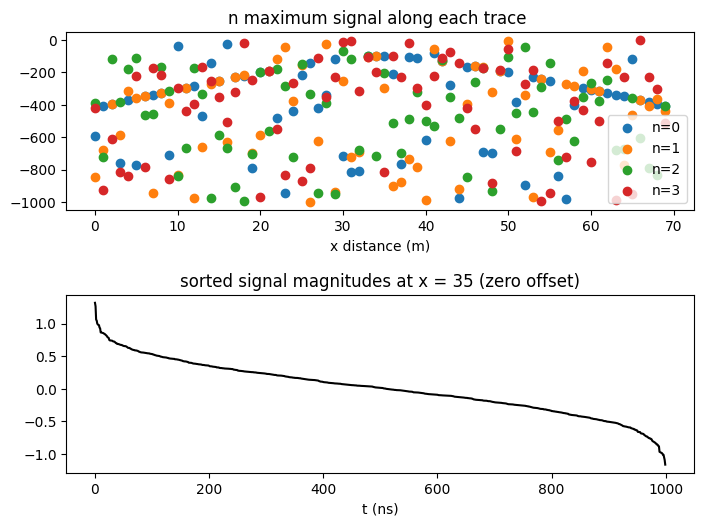

In [178]:
eps_r = 3                  # relative dielectric permittivity
rf = 400e6                 # radar frequency different from pulse frequency
dt = 1e-9                  # seconds
dx = 1                     # meters
region_shape = (70, 1e-6)  # grid (x,z)
wavetype = 'gaussian'
SNR = 0.02

# Point reflectors at (x,t) where x [m] and t [s]
reflectors = [(35, 50e-9)]

data, x_positions, t_samples = gprsim.gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR)

fig, ax = plt.subplots(2, figsize = (7,5))
fig.tight_layout(h_pad=4)

for n in range(0,4):
    t = data.argsort(axis=0)[::-1,:][n]* -1 # Ttake the indices of the max 5 signals
    x = np.arange(0, data.shape[1]) * dx # 
    ax[0].scatter(x, t, label=f"n={n}")

sample_signal = data[:,35]
ax[1].plot(np.sort(sample_signal)[::-1], c='black')
ax[1].set_title("sorted signal magnitudes at x = 35 (zero offset)")
ax[1].set_xlabel("t (ns)")
ax[0].legend()
ax[0].set_title("n maximum signal along each trace ")
ax[0].set_xlabel("x distance (m)")

# This looks quite nice, Lets gradually degrade the SNR ot see how the alg responds

In [182]:
# Parameters
eps_r = 3                  # relative dielectric permittivity
rf = 400e6                 # radar frequency different from pulse frequency
dt = 1e-9                  # seconds
dx = 1                     # meters
region_shape = (70, 1e-6)  # grid (x,z)
wavetype = 'gaussian'
# Point reflectors at (x,t) where x [m] and t [s]
reflectors = [(35, 50e-9)]
x_0, t_0 = reflectors[0][0], reflectors[0][1]

drs = []
dx0s = []
dt0s = []
for SNR in np.arange(0.0009,0.2,0.002):
    data, x_positions, t_samples = gprsim.gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR)
    v, z, x0, t0 = gprsim.fit_hyperbola(data, 1, 'robust_fit', dx, dt, lam=0.001)
    drs.append(((np.abs(eps_r-(3e8/v)**2)) / ((np.abs(eps_r+(3e8/v)**2))/2))*100)
    dx0s.append(((np.abs(x_0-x0)) / ((np.abs(x_0+x0)/2)))*100)
    dt0s.append(((np.abs(t_0-t0)) / ((np.abs(t_0+t0)/2)))*100)
        

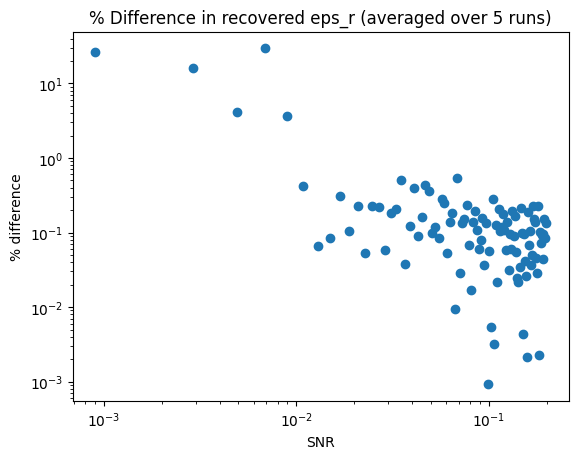

In [187]:
plt.scatter(np.arange(0.0009,0.2,0.002), drs); plt.title("% Difference in recovered eps_r (averaged over 5 runs)"); plt.xlabel("SNR"); plt.ylabel("% difference"); plt.xscale('log'); plt.yscale('log'); 


Caught invalud value in sqrt: can not calculate hyperbola parameters from pinv. Switching to np.polyfit to avoid distruption. If np.polyfit quits, the input data may be too noisy


AttributeError: 'float' object has no attribute 'argmax'

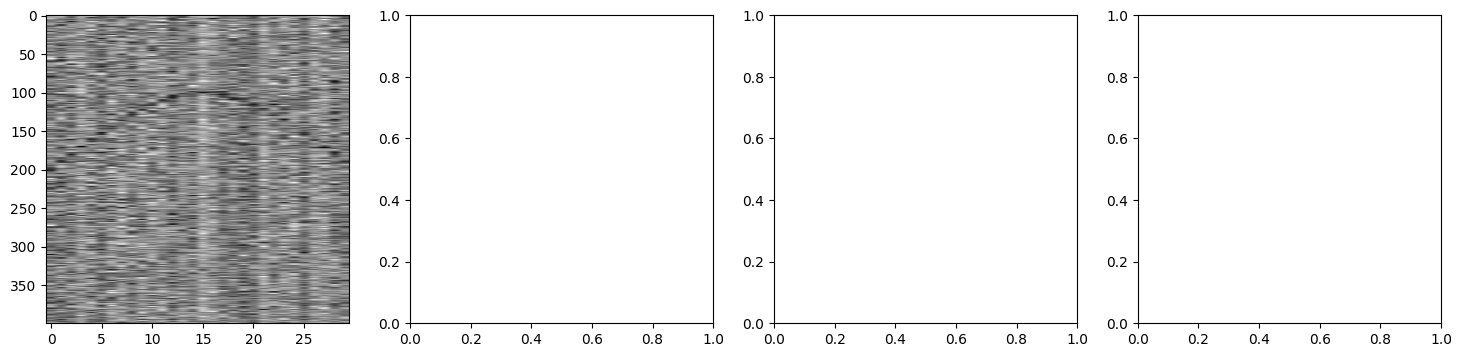

In [367]:
from gprsim import smooth_path_dp
from gprsim import fit_hyperbola
fig, ax = plt.subplots(1,4, figsize=(18,4))
# Parameters
eps_r = 3                  # relative dielectric permittivity
rf = 400e6                 # radar frequency different from pulse frequency
dt = 1e-9                  # seconds
dx = 1                     # meters
nx = 70
nt = 1e-6
region_shape = (nx, nt)  # grid (x,z)
wavetype = 'gaussian'
SNR = 0.01

# Point reflectors at (x,t) where x [m] and t [s]
reflectors = [(35, 50e-9)]

data, x_positions, t_samples = gprsim.gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR)
data = data[0:400, 20:50]
# im = ax[0].imshow(c-c.mean(axis=0), aspect="auto")
# im = ax[0].imshow(data, aspect="auto", cmap='binary', alpha=0.4)
# im2 = ax[1].imshow(data, aspect="auto", cmap='binary', alpha=0.4)
# im3 = ax[2].imshow(data, aspect="auto", cmap='binary', alpha=0.4)

'''
Plot the intensity only case
'''
x, t, c, b = smooth_path_dp(data, dx, lam=0) # Intensity only path
ax[0].imshow((c-c.min(axis=0))/(c.max(axis=0)-c.min(axis=0)),cmap='binary', aspect='auto')
v, z, x0, t0 = fit_hyperbola(data, 1, 'robust_fit', dx, dt, x, t)
ax[0].plot(x, (2*np.sqrt((x-x0)**2 + z**2))/(v*1e-9), c='tab:red', ls='--', lw=2)

'''
Plot the slope only case
'''
x, t, c, b = smooth_path_dp(data, dx, lam=1)
ax[1].imshow((c-c.min(axis=0))/(c.max(axis=0)-c.min(axis=0)),cmap='binary', aspect='auto')
v, z, x0, t0 = fit_hyperbola(data, 1, 'robust_fit', dx, dt, x, t)
ax[1].plot(x, (2*np.sqrt((x-x0)**2 + z**2))/(v*1e-9), c='tab:blue', ls='--', lw=2)

'''rfd
plot the optimal case
'''
# x, t, c, b = smooth_path_dp(data, dx, lam=0.001)
# ax[2].imshow((c-c.min(axis=0))/(c.max(axis=0)-c.min(axis=0)),cmap='binary', aspect='auto')
# v, z, x0, t0 = fit_hyperbola(data, 1, 'robust_fit', dx, dt, 0.001)
# ax[2].plot(x, (2*np.sqrt((x-x0)**2 + z**2))/(v*1e-9), c='y', ls='--', lw=2)
x, t = gprsim.minimize_tracewise_slope_window(data, 100, dx, 5)
v, z, x0, t0 = fit_hyperbola(data, 1, 'robust_fit', dx, dt, x, t)
ax[2].imshow((c-c.min(axis=0))/(c.max(axis=0)-c.min(axis=0)),cmap='binary', aspect='auto')
ax[2].plot(x, (2*np.sqrt((x-x0)**2 + z**2))/(v*1e-9), c='y', ls='--', lw=2)


ax[3].imshow(data, aspect="auto", cmap='seismic')



NameError: name 't_max' is not defined

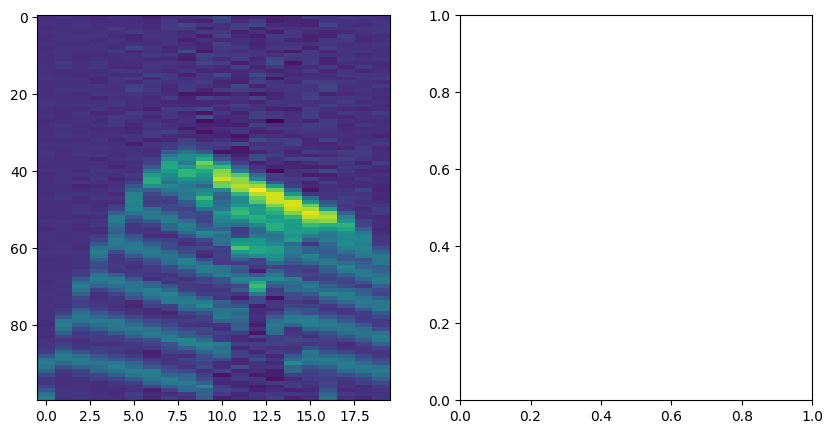

In [1123]:
import numpy as np
import matplotlib.pyplot as plt
import gprsim
from scipy.interpolate import interp1d

eps_r = 3                  # relative dielectric permittivity
rf = 400e6                 # radar frequency different from pulse frequency
dt = 1e-9                  # seconds
dx = 1                     # meters
Xlim = 20
Tlim = 1e-7
region_shape = (Xlim, Tlim)  # grid (x,z)
Nx, Nt = int(Xlim/dx), int(Tlim/dt)
wavetype = 'gaussian'
SNR = 100

# Point reflectors at (x,t) where x [m] and t [s]
reflectors = [(7, 20e-9), (8, 18e-9), (9, 19e-9), (10, 20e-9), (11, 21e-9), (12, 22e-9), (13, 23e-9), (14, 24e-9), (15, 25e-9), (16, 26e-9)]

data, x_positions, t_samples = gprsim.gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR)


fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].imshow(data, aspect="auto")
# --- Velocity model (constant) ---
c0 = 3e8
v = c0 / np.sqrt(eps_r)

# --- Output migration grid ---
x_img = x_positions.copy()       # same as input x
z_img = np.linspace(0, v*t_max/2, Nt) 
# converting time window to max depth: z_max = v * t_max / 2

migrated = np.zeros((len(x_img), len(z_img)))

# --- Migration Loop ---
for ix, x in enumerate(x_img):
    for iz, z in enumerate(z_img):

        # Travel time curve T(x_s; x,z) for all traces
        # Two-way travel time in constant velocity
        T = 2.0 * np.sqrt((x_positions - x)**2 + z**2) / v

        # Only use times inside the data window
        valid = (T >= t_samples[0]) & (T <= t_samples[-1])
        if not np.any(valid):
            continue
            
        # Interpolate each trace’s data at time T
        amplitudes = np.zeros_like(T)
        for isrc in np.where(valid)[0]:
            f = interp1d(t_samples, data[:, isrc], kind='linear', fill_value=0, bounds_error=False)
            amplitudes[isrc] = f(T[isrc])

        # Sum contributions (simplest Kirchhoff)
        migrated[ix, iz] = np.sum(amplitudes)

# --- Plot result ---
ax[1].imshow(migrated.T, aspect="auto", extent=[x_img.min(), x_img.max(), z_img.max(), z_img.min()])
ax[1].set_title("Kirchhoff Migrated Section")
ax[1].set_xlabel("Distance (m)")
ax[1].set_ylabel("Depth (m)")


In [45]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [288]:
import pandas as pd

# Load the CSV file into a pandas DataFrame
import csv

# Reading a CSV file into a list of lists
dates_t = []
tornados = []
with open('/Users/coltenrodriguez/Downloads/data (4).csv', 'r', newline='') as csvfile:
    reader = csv.reader(csvfile)
    i = 0
    for row in reader:
        if i>2:
            dates_t.append(row[0])
            tornados.append(row[1])
        i+=1
        

In [173]:
import numpy as np

def sec(theta):
    return 1/(np.cos(theta))
    
def transmission_angles(er, h, xq, zq, xa):
    # theta_gv: 0 → pi/2, with 2^11 points
    theta_gv = np.linspace(0, np.pi/2, 2**11)

    # theta_av = asin(min(sqrt(er)*sin(theta_gv), 1))
    # np.minimum applies elementwise
    inside = np.sqrt(er) * np.sin(theta_gv)
    inside = np.minimum(inside, 1.0)
    theta_av = np.arcsin(inside)

    # Compute absolute error array exactly like MATLAB
    diff = np.abs(np.abs(xa - xq) - zq * np.tan(theta_gv) - h * np.tan(theta_av))

    # Find index of minimum
    ind_min = np.argmin(diff)

    # Return angles
    theta_a = theta_av[ind_min]
    theta_g = theta_gv[ind_min]

    return theta_a, theta_g

def kirchoff_migration_2D(B, h, er, t, xA, xQ, zQ):
    # B: preprocessed B-scan
    # h: Antenna height
    # er: relative permitivity
    # t = time vector
    # zA: spatial vecotr (sampling)

    # output I: image, claculated as xQ x zQ rectangle , abs[I], rows should be depth, cols should be xQ

    c = 3e8 # speed of light in a vac
    Nt = t.shape[0]
    NxQ = xQ.shape[0]
    NzQ = zQ.shape[0]
    NxA = xA.shape[0]
    
    # Initialize the kernel
    kernel = np.zeros((NxA, NxQ, NxQ))
    print(kernel.shape)

    # calculate the half derivative
    Fs = None # sampling frequency
    f = None   

    # B_f = np.fft.fftshift(np.fft.fft(B, 0), 0) # f-x domain
    # D12 = np.tile(np.sqrt(1j * 2 * np.pi * f.T), (1,NxA)) # half derivative operator
    # dB = np.real(np.ifft(np.fft.fftshift(D12*B_f, 1), 1))
    dB = B

    for m in range(NxQ):
        xq = xQ[m]
        for n in range(NzQ):
            zq = zQ[n]
            theta_av = np.zeros((NxA, 1))
            theta_gv = np.zeros((NxA, 1))
            for p in range(NxA):
                (theta_a, theta_g) = transmission_angles(er, h, xq, zq, xA[p])
                theta_av[p] = theta_a
                theta_gv[p] = theta_g
            r = h * sec(theta_av) + zq * sec(theta_gv)
            t_exps = 2*(h*sec(theta_av/c) + zq*sec(theta_gv)/(c*np.sqrt(er)))

            # select the correct theta from dB
            # Trace out the hyp
            # replicate MATLAB repmat(t, [NxA, 1])
            t_rep = np.tile(t, (NxA, 1))      # shape: (NxA, len(t))
            
            # find index of minimum along axis=1 (MATLAB dim=2)
            inds = np.argmin(np.abs(t_rep - t_exps), axis=1)
            
            # convert (row, col) pairs → linear indices like MATLAB sub2ind
            rows = inds                     # row indices
            cols = np.arange(1, NxA+1) - 1  # MATLAB 1:NxA → Python 0:NxA-1
            
            # linearized index into dB
            lin_inds = rows * dB.shape[1] + cols
            
            # construct the kernel
            print((np.cos(theta_av)/np.sqrt(r))
            kernel[:, m, n] = np.cos(theta_av)/np.sqrt(r) * dB[lin_inds]

    I = np.abs(np.trapz(kernelm, x=zA, axis=0)).squeeze().T
    return I

    
    
# Read in B-scan data
B = data
meta = None

x = np.arange(nx) # positions of scans
t = np.arange(nt) # time

# perform preprocessing
BKGR = B-B.mean(axis=0)

# No filtering
BKGR_filtered = BKGR

# perform kirchoff migration
h = 0.1 # Height of the antenna
er = 3.0 # rel permitivity
xQ = x
zQ = np.arange(0, 0.4, 5e-3) # Why a 5mm increment?
I = kirchoff_migration_2D(BKGR_filtered, h, er, t, x, xQ, zQ)
plt.imshow(I, apect='auto')

(70, 70, 70)
(70, 1)


ValueError: could not broadcast input array from shape (70,30) into shape (70,)

In [1]:
pip install "laspy[lazrs,laszip]"

Note: you may need to restart the kernel to use updated packages.


In [265]:
data = {'Riveria': {
    '2002': {
        'x': [],
        'y': []},
    '2016': {
        'x': [],
        'y': []},
    },
        'Cottons': {
    '2002': {
        'x': [],
        'y': []},
    '2016': {
        'x': [],
        'y': []},
    },
        'Barb-wire': {
    '2002': {
        'x': [],
        'y': []},
    '2016': {
        'x': [],
        'y': []},
    },
        'Uppers': {
    '2002': {
        'x': [],
        'y': []},
    '2016': {
        'x': [],
        'y': []},
    },
        'Lowers': {
    '2002': {
        'x': [],
        'y': []},
    '2016': {
        'x': [],
        'y': []},
    }
}


In [214]:
import laspy

path = "/Users/coltenrodriguez/Downloads/20020522_scripps_333750_ld_p19.copc.laz"
las = laspy.read(path)

print(las)

<LasData(1.4, point fmt: <PointFormat(6, 0 bytes of extra dims)>, 23401317 points, 2 vlrs)>


In [ ]:
data2[]

In [215]:
x = las.x[::100]
y = las.y[::100]
z = las.z[::100]

In [216]:
intensity = las.intensity
classification = las.classification
return_num = las.return_number

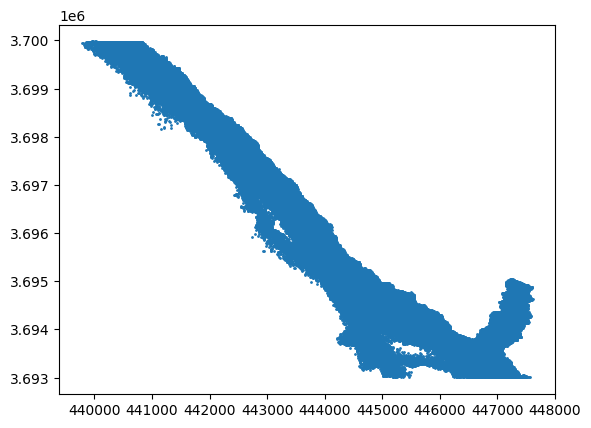

3693004.2589775175 3699976.7189775174


In [226]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y, s=1)
plt.show()
print(min(y), max(y))

In [814]:
import numpy as np
from shapely.geometry import LineString, Point
import laspy
from pyproj import Transformer
import numpy as np

paths = ["/Users/coltenrodriguez/Downloads/20140906_ncmp_ca_24.copc.laz", "/Users/coltenrodriguez/Downloads/20140906_ncmp_ca_23.copc.laz"]
paths = ["/Users/coltenrodriguez/Downloads/20090909_NCMP_CA023_H_ld_p10.copc.laz", "/Users/coltenrodriguez/Downloads/20090909_NCMP_CA024_H_ld_p10.copc.laz"]
x, y, z = [], [], []
for path in paths:
    las = laspy.read(path)
    # print(f'{src_crs}, \n \n {las.header.parse_crs()}')
    # transformer = Transformer.from_crs(src_crs, las.header.parse_crs(), always_xy=True)
    # x_shift, y_shift = transformer.transform(las.x[::1000], las.y[::1000])
    # x+=list(x_shift)
    # y+=list(y_shift)
    x+=las.x[::10]
    y+=las.y[::10]
    z+=las.z[::10]

In [815]:
print(len(x), len(y), len(z))

93352 93352 93352


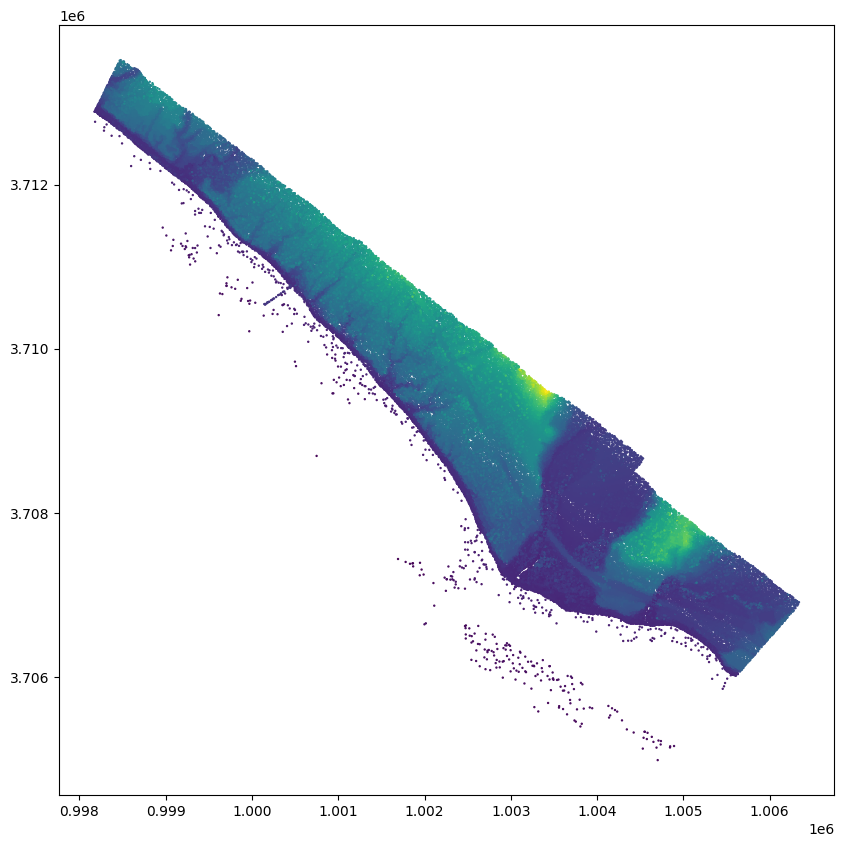

In [803]:
fig = plt.figure(figsize=(10,10))
plt.scatter(x[::50], y[0::50], s=0.5, c=np.array(z)[0::50]/max(z))

In [811]:
data3 = data2

In [898]:
import numpy as np

# transects = {'Riveria': {'P1': np.array([442434.6,3696739.4]), 'P2': np.array([443232.1,3697292.6])},
#              'Cottons': {'P1': np.array([444118.7,3694580.6]), 'P2': np.array([444817.0,3695228.5])},
#              'Barb-wire': {'P1': np.array([444272.2,3694187.2]), 'P2': np.array([445074.8,3694985.2])},
#              'Uppers': {'P1': np.array([444672.8,3693212.2]), 'P2': np.array([445580.0,3694659.9])},
#              'Lowers': {'P1': np.array([445699.0,3693250.8]), 'P2':np.array([446056.1,3694254.6])}}

transects = {'Riveria': {'P1': np.array([1000624.796,3709534.613]), 'P2': np.array([1001391.465,3710134.938])},
             'Cottons': {'P1': np.array([1002436.267,3707470.483]), 'P2': np.array([1003098.040,3708159.742])},
             'Barb-wire': {'P1': np.array([1002612.739,3707085.406]), 'P2': np.array([1003370.384,3707931.062])},
             'Uppers': {'P1': np.array([1003070.48,3706132.41]), 'P2': np.array([1003895.0328,3707634.4632])},
             'Lowers': {'P1': np.array([1004095.786,3706230.124]), 'P2':np.array([1004395.2719,3707256.1592])}}

# transects = {'Riveria': {'P1': np.array([33.40844003,-117.61909132]), 'P2': np.array([33.413471609,-117.610549861])},
#              'Cottons': {'P1': np.array([33.389057886,-117.600846299]), 'P2': np.array([33.394937546,-117.593377963])},
#              'Barb-wire': {'P1': np.array([33.385517709,-117.599171411]), 'P2': np.array([33.392756557,-117.590591152])},
#              'Uppers': {'P1': np.array([33.376744579,-117.594804685]), 'P2': np.array([33.389848238,-117.585139608])},
#              'Lowers': {'P1': np.array([33.377145242,-117.583775214]), 'P2':np.array([33.386216702,-117.579996361])}}

transects = {'Riveria': {'P1': np.array([1000624.796,3709534.613]), 'P2': np.array([1001391.465,3710134.938])},
             'Cottons': {'P1': np.array([1002393.32,3707579.29]), 'P2': np.array([1003238.092,3707992.622])},
             'Barb-wire': {'P1': np.array([1002611.44,3707082.63]), 'P2': np.array([1003500.251,3707815.315])},
             'Uppers': {'P1': np.array([1003070.230,3706132.112]), 'P2': np.array([1003895.065,3707634.470])},
             'Lowers': {'P1': np.array([1004095.786,3706230.124]), 'P2':np.array([1004395.2719,3707256.1592])}}

for transect in transects.keys():
    region = transect
    P1 = transects[region]['P1']
    P2 = transects[region]['P2']
    buffer_dist = 10.0   # meters on each side
    
    pts = np.vstack([x, y]).T   # shape (N,2)
    
    line_vec = P2 - P1
    line_len = np.linalg.norm(line_vec)
    line_unit = line_vec / line_len
    
    # Vector from P1 to every point
    p1_to_pts = pts - P1
    
    # Perpendicular distance to line (using 2D cross product magnitude)
    dist = np.abs(np.cross(line_unit, p1_to_pts))
    
    mask = dist <= buffer_dist
    x_sel = np.array(x)[mask]
    y_sel = np.array(y)[mask]
    z_sel = np.array(z)[mask]
    p1_to_pts_sel = p1_to_pts[mask]
    
    s_along = np.dot(p1_to_pts_sel, line_unit)   # distance along transect

    seg_mask = (s_along >= 0) & (s_along <= line_len)
    s_along = s_along[seg_mask]
    z_sel = z_sel[seg_mask]

    data3[region]['2009']['x'], data3[region]['2009']['y'] = s_along[z_sel != np.max(z_sel)], z_sel[z_sel != np.max(z_sel)]

In [745]:
# data[region]['2002']['x'], data[region]['2002']['y'] = s_along[z_sel != np.max(z_sel)], z_sel[z_sel != np.max(z_sel)]

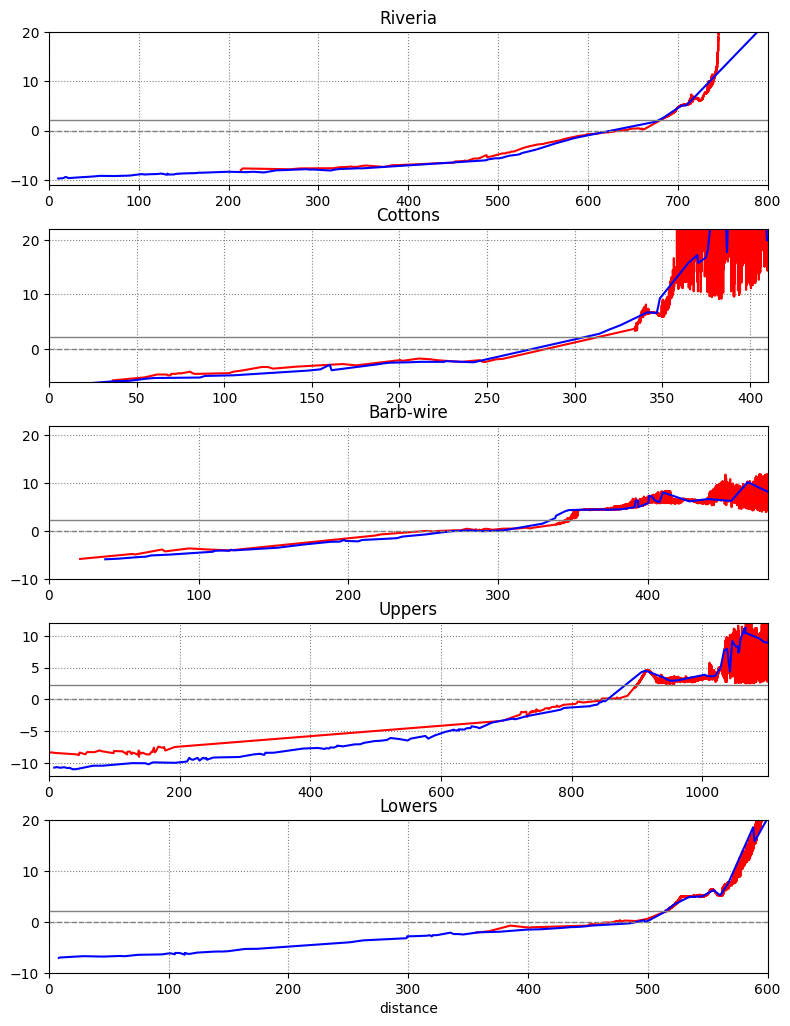

In [1077]:
fix, ax = plt.subplots(5,1, figsize=(8,10))
lims = [(0, 800), (0, 410), (0, 480), (0, 1100), (0, 600)]
limsy = [(-11, 20), (-6, 22), (-10, 22), (-12, 12), (-10, 20)]

sl = 0
mhw = 2.2

plt.tight_layout()
transects = {'Riveria': {'P1': np.array([1000624.796,3709534.613]), 'P2': np.array([1001391.465,3710134.938])},
             'Cottons': {'P1': np.array([1002393.32,3707579.29]), 'P2': np.array([1003238.092,3707992.622])},
             'Barb-wire': {'P1': np.array([1002611.44,3707082.63]), 'P2': np.array([1003500.251,3707815.315])},
             'Uppers': {'P1': np.array([1003070.230,3706132.112]), 'P2': np.array([1003895.065,3707634.470])},
             'Lowers': {'P1': np.array([1004095.786,3706230.124]), 'P2':np.array([1004395.2719,3707256.1592])}}
for i, region in enumerate(transects.keys()):
    # ax[i].scatter(np.array(data[region]['2002']['x']), data[region]['2002']['y'], s=1)
    # ax[i].scatter(np.array(data[region]['2016']['x']), data[region]['2016']['y'], s=1)
    idx_sort_2002 = np.argsort(np.array(data3[region]['2002']['x']))
    idx_sort_2016 = np.argsort(np.array(data3[region]['2016']['x']))
    idx_sort_2009 = np.argsort(np.array(data3[region]['2009']['x']))
    # ax[i].scatter(np.array(data2[region]['2002']['x'])[idx_sort_2002], data2[region]['2002']['y'][idx_sort_2002], color="blue", label="2016", s=5)
    ax[i].plot(np.array(data3[region]['2016']['x'])[idx_sort_2016], data3[region]['2016']['y'][idx_sort_2016],  color="red", label="2015")
    ax[i].plot(np.array(data3[region]['2009']['x'])[idx_sort_2009], data3[region]['2009']['y'][idx_sort_2009],  color="blue", label="2009")
    
    ax[i].grid(linestyle=':', color='0.5')
    # plot the relevant sea levels
    ax[i].axhline(y=sl, color='gray', linestyle='--', linewidth=1)
    ax[i].axhline(y=mhw, color='gray', linewidth=1, label='MHW (from Webb et. al. 2023)')
    ax[i].set_title(region)
    
    if i == 4:
        ax[i].set_xlabel("distance")
    ax[i].set_xlim(lims[i][0], lims[i][1])
    ax[i].set_ylim(limsy[i][0], limsy[i][1])

In [895]:
seabed_gradients = {"Uppers": {}, "Lowers": {}}

In [1121]:
transects = {'Riveria': {'P1': np.array([1000624.796,3709534.613]), 'P2': np.array([1001391.465,3710134.938])},
             'Cottons': {'P1': np.array([1002393.32,3707579.29]), 'P2': np.array([1003238.092,3707992.622])},
             'Barb-wire': {'P1': np.array([1002611.44,3707082.63]), 'P2': np.array([1003500.251,3707815.315])},
             'Uppers': {'P1': np.array([1003070.230,3706132.112]), 'P2': np.array([1003895.065,3707634.470])},
             'Lowers': {'P1': np.array([1004095.786,3706230.124]), 'P2':np.array([1004395.2719,3707256.1592])}}
transects_raw = [[[1000723.5786545137, 3709529.6397403437], [1001391.0387262963, 3710125.3892259016]], [[1000875.2741253733, 3709251.071693856], [1001655.8162754332, 3709890.9507709364]], [[1001029.7276957032, 3709033.181835712], [1001829.5765420543, 3709642.721818621]], [[1001170.3907686822, 3708721.516595582], [1002047.4664001982, 3709344.847075842]], [[1001407.5873231173, 3708445.017123697], [1002295.695352514, 3709087.654300248]], [[1001691.6715685454, 3708177.4814750897], [1002681.8292783386, 3708742.891866476]], [[1001788.2050500016, 3707845.820013801], [1002913.5096338334, 3708320.2131226715]], [[1002295.695352514, 3707608.623459366], [1003252.7558686651, 3707991.9992857208]], [[1002364.6478392684, 3707208.0095113227], [1003487.1943236301, 3707823.065693172]], [[1003258.2720676054, 3706189.58128196], [1003895.3930452161, 3707563.1148181073]], [[1004640.0799021636, 3705949.6266280543], [1004769.7105772619, 3707044.592117714]], [[1000794.6898177066, 3709324.046809477], [1001552.518514835, 3710032.0528586973]], [[1001009.7138770994, 3709153.6009087386], [1001720.3421709464, 3709803.9175761705]], [[1001030.6918341133, 3708817.9535965156], [1001956.3441873533, 3709507.603933349]], [[1001583.985450356, 3708264.004419117], [1002352.3031259914, 3708990.366180724]], [[1001806.876243629, 3708129.6143819955], [1002724.6618629886, 3708522.9510760065]], [[1002181.8572252531, 3707854.2786961873], [1003117.998557, 3708150.592339009]], [[1002444.0816879271, 3707418.3305269917], [1003393.3342428077, 3707879.845581298]], [[1002661.7279919467, 3706830.9477306018], [1003445.7791353426, 3707706.7774359332]], [[1002986.8863256627, 3706332.0656903638], [1003590.0025898133, 3707784.7892135787]], [[1003742.0927781644, 3706019.363018624], [1003823.3823615934, 3707325.896403899]], [[1004014.8062193455, 3705924.9622120615], [1004161.651918443, 3707152.1726973765]], [[1004271.0367089561, 3705967.9993856233], [1004418.6911472053, 3707053.8003575676]]]
shoreline_change = np.linspace(0.24, 2.1, len(transects.keys())) # The modled rate of shoreline recession at each transect

for i, region in enumerate(transects.keys()):
    if i > 2:
        idx_sort_2002 = np.argsort(np.array(data3[region]['2002']['x']))
        idx_sort_2016 = np.argsort(np.array(data3[region]['2016']['x']))
        idx_sort_2009 = np.argsort(np.array(data3[region]['2009']['x']))
        # 2009
        x_sorted_09 = data3[region]['2009']['x'][idx_sort_2009]
        y_sorted_09 = data3[region]['2009']['y'][idx_sort_2009]
        ind_int09 = np.where(y_sorted_09 > 0)[0][0]
        gradient09 = ((y_sorted_09[ind_int09]-y_sorted_09[0])/(x_sorted_09[ind_int09]-x_sorted_09[0]))
        seabed_gradients[region]["2009"] = gradient09
        
        # 2014
        x_sorted_16 = data3[region]['2016']['x'][idx_sort_2016]
        y_sorted_16 = data3[region]['2016']['y'][idx_sort_2016]
        ind_int16 = np.where(y_sorted_16 > 0)[0][0]
        gradient16 = ((y_sorted_16[ind_int16]-y_sorted_16[0])/(x_sorted_16[ind_int16]-x_sorted_16[0]))
        seabed_gradients[region]["2014"] = gradient16
        
        dgrad = (gradient16-gradient09)/6
        years = 6
        change_tolerance = 0.2 # 20% tolerance
        observed_change = abs(x_sorted_16[ind_int16]-x_sorted_09[ind_int09])/years
        expected_change = (years*shoreline_change[i])
        how_differ = 1
        if not ((expected_change*(1-change_tolerance))<observed_change<(expected_change*(1+change_tolerance))): # If the change in shoreline position is greater than what is expected by our model, there is a season disconnect, 20cm of tolerance
            how_differ = (observed_change/expected_change)
            #######################################################################
            #        From here we should calculate the volume of sediment         #
            #        expected to be redistributed and adjust that way, but        #
            #        for our crude estimation, just use this as the scaling       #
            #######################################################################
        
        print(how_differ)
        dgrad=(((slope16-slope09)/6)*(how_differ)) # gradient * scaling factor
        
        seabed_gradients[region]["2025"] = gradient16 + (dgrad*11)
        seabed_gradients[region]["2028"] = gradient16 + (dgrad*14)
        


1
0.2989172649323144


In [1122]:
seabed_gradients

{'Uppers': {'2009': np.float64(0.016676200553477086),
  '2014': np.float64(0.009985796337431314),
  '2025': np.float64(0.06897079550365567),
  '2028': np.float64(0.0850576134580805)},
 'Lowers': {'2009': np.float64(0.015088484714906788),
  '2014': np.float64(0.01944732351963834),
  '2025': np.float64(0.03707895814244097),
  '2028': np.float64(0.04188758576684169)}}

In [1120]:
seabed_gradients = {'Uppers': {'2009': np.float64(0.016676200553477086),
  '2014': np.float64(0.011327975937141289),
  '2025': np.float64(0.0015228974738589942),
  '2028': np.float64(-0.0011512148343089043)},
 'Lowers': {'2009': np.float64(0.015088484714906788),
  '2014': np.float64(0.02895035088062063),
  '2025': np.float64(0.05436377218442935),
  '2028': np.float64(0.06129470526728627)}}


In [1044]:
transects = [[[1000723.5786545137, 3709529.6397403437], [1001391.0387262963, 3710125.3892259016]], [[1000875.2741253733, 3709251.071693856], [1001655.8162754332, 3709890.9507709364]], [[1001029.7276957032, 3709033.181835712], [1001829.5765420543, 3709642.721818621]], [[1001170.3907686822, 3708721.516595582], [1002047.4664001982, 3709344.847075842]], [[1001407.5873231173, 3708445.017123697], [1002295.695352514, 3709087.654300248]], [[1001691.6715685454, 3708177.4814750897], [1002681.8292783386, 3708742.891866476]], [[1001788.2050500016, 3707845.820013801], [1002913.5096338334, 3708320.2131226715]], [[1002295.695352514, 3707608.623459366], [1003252.7558686651, 3707991.9992857208]], [[1002364.6478392684, 3707208.0095113227], [1003487.1943236301, 3707823.065693172]], [[1003258.2720676054, 3706189.58128196], [1003895.3930452161, 3707563.1148181073]], [[1004640.0799021636, 3705949.6266280543], [1004769.7105772619, 3707044.592117714]], [[1000794.6898177066, 3709324.046809477], [1001552.518514835, 3710032.0528586973]], [[1001009.7138770994, 3709153.6009087386], [1001720.3421709464, 3709803.9175761705]], [[1001030.6918341133, 3708817.9535965156], [1001956.3441873533, 3709507.603933349]], [[1001583.985450356, 3708264.004419117], [1002352.3031259914, 3708990.366180724]], [[1001806.876243629, 3708129.6143819955], [1002724.6618629886, 3708522.9510760065]], [[1002181.8572252531, 3707854.2786961873], [1003117.998557, 3708150.592339009]], [[1002444.0816879271, 3707418.3305269917], [1003393.3342428077, 3707879.845581298]], [[1002661.7279919467, 3706830.9477306018], [1003445.7791353426, 3707706.7774359332]], [[1002986.8863256627, 3706332.0656903638], [1003590.0025898133, 3707784.7892135787]], [[1003742.0927781644, 3706019.363018624], [1003823.3823615934, 3707325.896403899]], [[1004014.8062193455, 3705924.9622120615], [1004161.651918443, 3707152.1726973765]], [[1004271.0367089561, 3705967.9993856233], [1004418.6911472053, 3707053.8003575676]]]

paths = ["/Users/coltenrodriguez/Downloads/20090909_NCMP_CA023_H_ld_p10.copc.laz", "/Users/coltenrodriguez/Downloads/20090909_NCMP_CA024_H_ld_p10.copc.laz"]
x, y, z = [], [], []
for path in paths:
    las = laspy.read(path)
    # print(f'{src_crs}, \n \n {las.header.parse_crs()}')
    # transformer = Transformer.from_crs(src_crs, las.header.parse_crs(), always_xy=True)
    # x_shift, y_shift = transformer.transform(las.x[::1000], las.y[::1000])
    # x+=list(x_shift)
    # y+=list(y_shift)
    x+=las.x[::10]
    y+=las.y[::10]
    z+=las.z[::10]

data09 = []
for i in range(len(transects)):
    P1 = np.array(transects[i][0])
    P2 = np.array(transects[i][1])

    
    buffer_dist = 10.0   # meters on each side

    pts = np.vstack([x, y]).T   # shape (N,2)

    line_vec = P2 - P1
    line_len = np.linalg.norm(line_vec)
    line_unit = line_vec / line_len

    # Vector from P1 to every point
    p1_to_pts = pts - P1
    
    # Perpendicular distance to line (using 2D cross product magnitude)
    dist = np.abs(np.cross(line_unit, p1_to_pts))
    
    mask = dist <= buffer_dist
    x_sel = np.array(x)[mask]
    y_sel = np.array(y)[mask]
    z_sel = np.array(z)[mask]
    p1_to_pts_sel = p1_to_pts[mask]

    s_along = np.dot(p1_to_pts_sel, line_unit)   # distance along transect
    
    seg_mask = (s_along >= 0) & (s_along <= line_len)
    s_along = s_along[seg_mask]
    z_sel = z_sel[seg_mask]
    data09.append([s_along[z_sel != np.max(z_sel)], z_sel[z_sel != np.max(z_sel)]]) # x [m], y[m] data

paths = ["/Users/coltenrodriguez/Downloads/20140906_ncmp_ca_24.copc.laz", "/Users/coltenrodriguez/Downloads/20140906_ncmp_ca_23.copc.laz"]
x, y, z = [], [], []
for path in paths:
    las = laspy.read(path)
    # print(f'{src_crs}, \n \n {las.header.parse_crs()}')
    # transformer = Transformer.from_crs(src_crs, las.header.parse_crs(), always_xy=True)
    # x_shift, y_shift = transformer.transform(las.x[::1000], las.y[::1000])
    # x+=list(x_shift)
    # y+=list(y_shift)
    x+=las.x[::10]
    y+=las.y[::10]
    z+=las.z[::10]
data16 = []
for i in range(len(transects)):
    P1 = np.array(transects[i][0])
    P2 = np.array(transects[i][1])
    buffer_dist = 10.0   # meters on each side

    pts = np.vstack([x, y]).T   # shape (N,2)

    line_vec = P2 - P1
    line_len = np.linalg.norm(line_vec)
    line_unit = line_vec / line_len

    # Vector from P1 to every point
    p1_to_pts = pts - P1
    
    # Perpendicular distance to line (using 2D cross product magnitude)
    dist = np.abs(np.cross(line_unit, p1_to_pts))
    
    mask = dist <= buffer_dist
    x_sel = np.array(x)[mask]
    y_sel = np.array(y)[mask]
    z_sel = np.array(z)[mask]
    p1_to_pts_sel = p1_to_pts[mask]

    s_along = np.dot(p1_to_pts_sel, line_unit)   # distance along transect
    
    seg_mask = (s_along >= 0) & (s_along <= line_len)
    s_along = s_along[seg_mask]
    z_sel = z_sel[seg_mask]
    data16.append([s_along[z_sel != np.max(z_sel)], z_sel[z_sel != np.max(z_sel)]]) # x [m], y[m] data



/var/folders/vv/wqjks1114hz5w6vtzybkd8gc0000gn/T/ipykernel_28692/3998719822.py:34: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = np.abs(np.cross(line_unit, p1_to_pts))
/var/folders/vv/wqjks1114hz5w6vtzybkd8gc0000gn/T/ipykernel_28692/3998719822.py:77: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = np.abs(np.cross(line_unit, p1_to_pts))


(0.0, 400.0)

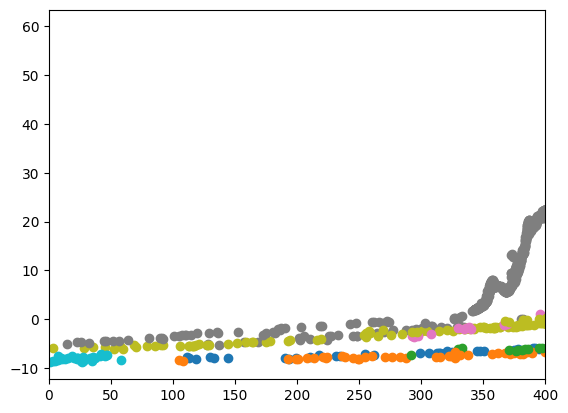

In [1056]:
for i in range(len(transects)):
    # Sort get the ind that sort the vals in increasing x order
    idx_sort_2016 = np.argsort(np.array(data16[i][0]))
    idx_sort_2009 = np.argsort(np.array(data09[i][0]))

    #############
    # 2016 data #
    #############
    # Sort the arrays by increasing x
    x_sorted_16 = np.array(data16[i][0][idx_sort_2016])
    y_sorted_16 = np.array(data16[i][1][idx_sort_2016])
    plt.scatter(x_sorted_16, y_sorted_16)
plt.xlim(0,400)

3.798088686547353
3.445655599019493
1
2.3215560953777876
1
0.01418517598772202
0.21930749870765343
0.5747600015515163
0.12145074941914215
1.429704949354787
0.034959443880544956
1.326475217604586
1
0.5771193580390412
0.5131813465519728
0.058649286300622966
0.010730050624908047
0.10434605127432306
0.20926300180973728
0.5191102371178257
1.2494627156053315
0.3845473151692216
1


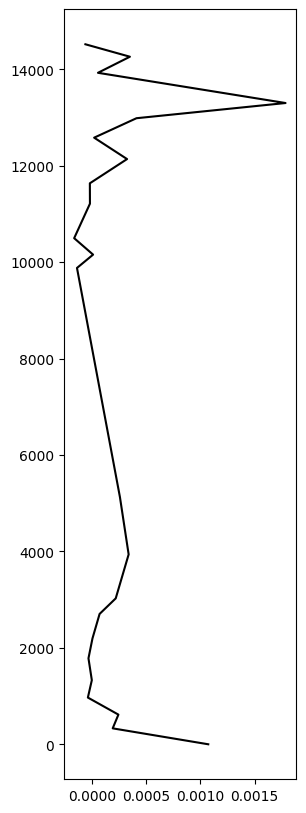

In [1115]:
# def slope(p1, p2):
#     return (p2[1]-p1[1])/(p2[0]-p1[0])

# def extend_line(lines, extend_length=100):
#     return_array = np.zeros_like(lines, dtype=float)

#     for i, line in enumerate(lines):
#         P1 = np.array(line[0], dtype=float)
#         P2 = np.array(line[1], dtype=float)

#         # Identify leftmost point (smallest x)
#         if P2[0] < P1[0]:
#             P1, P2 = P2, P1   # swap so P1 is always leftmost

#         # Direction vector from P1 → P2
#         v = P2 - P1
#         L = np.linalg.norm(v)

#         # Normalize direction
#         u = v / L

#         # Extend BACKWARDS from P1
#         P1_new = P1 - extend_length * u

#         return_array[i] = [P1_new, P2]

#     return return_array
    
transects = [[[1000723.5786545137, 3709529.6397403437], [1001391.0387262963, 3710125.3892259016]], [[1000875.2741253733, 3709251.071693856], [1001655.8162754332, 3709890.9507709364]], [[1001029.7276957032, 3709033.181835712], [1001829.5765420543, 3709642.721818621]], [[1001170.3907686822, 3708721.516595582], [1002047.4664001982, 3709344.847075842]], [[1001407.5873231173, 3708445.017123697], [1002295.695352514, 3709087.654300248]], [[1001691.6715685454, 3708177.4814750897], [1002681.8292783386, 3708742.891866476]], [[1001788.2050500016, 3707845.820013801], [1002913.5096338334, 3708320.2131226715]], [[1002295.695352514, 3707608.623459366], [1003252.7558686651, 3707991.9992857208]], [[1002364.6478392684, 3707208.0095113227], [1003487.1943236301, 3707823.065693172]], [[1003258.2720676054, 3706189.58128196], [1003895.3930452161, 3707563.1148181073]], [[1004640.0799021636, 3705949.6266280543], [1004769.7105772619, 3707044.592117714]], [[1000794.6898177066, 3709324.046809477], [1001552.518514835, 3710032.0528586973]], [[1001009.7138770994, 3709153.6009087386], [1001720.3421709464, 3709803.9175761705]], [[1001030.6918341133, 3708817.9535965156], [1001956.3441873533, 3709507.603933349]], [[1001583.985450356, 3708264.004419117], [1002352.3031259914, 3708990.366180724]], [[1001806.876243629, 3708129.6143819955], [1002724.6618629886, 3708522.9510760065]], [[1002181.8572252531, 3707854.2786961873], [1003117.998557, 3708150.592339009]], [[1002444.0816879271, 3707418.3305269917], [1003393.3342428077, 3707879.845581298]], [[1002661.7279919467, 3706830.9477306018], [1003445.7791353426, 3707706.7774359332]], [[1002986.8863256627, 3706332.0656903638], [1003590.0025898133, 3707784.7892135787]], [[1003742.0927781644, 3706019.363018624], [1003823.3823615934, 3707325.896403899]], [[1004014.8062193455, 3705924.9622120615], [1004161.651918443, 3707152.1726973765]], [[1004271.0367089561, 3705967.9993856233], [1004418.6911472053, 3707053.8003575676]]]


dgrad = []
grad09 = []
grad16 = []
shoreline_change = np.linspace(0.24, 2.1, len(transects)) # The modled rate of shoreline recession at each transect

for i in range(len(transects)):
    # get the indexes that sort the vals in increasing x order
    idx_sort_2016 = np.argsort(np.array(data16[i][0]))
    idx_sort_2009 = np.argsort(np.array(data09[i][0]))

    ##########################
    #        2015 data       #
    ##########################
    # Sort the arrays by increasing x
    x_sorted_16 = np.array(data16[i][0][idx_sort_2016])
    y_sorted_16 = np.array(data16[i][1][idx_sort_2016])

    # Where cross sl?
    ind_int16 = np.where(y_sorted_16 > 0)[0][0]

    # Calculate seabed gradient
    slope16 = (y_sorted_16[ind_int16] - y_sorted_16[0])/(x_sorted_16[ind_int16] - x_sorted_16[0])
    
    ##########################
    #        2009 data       #
    ##########################
    x_sorted_09 = np.array(data09[i][0][idx_sort_2009])
    y_sorted_09 = np.array(data09[i][1][idx_sort_2009])
    
    # Where cross sl?
    ind_int09 = np.where(y_sorted_09 > 0)[0][0]

    # Calculate seabed gradient
    slope09 = (y_sorted_09[ind_int09] - y_sorted_09[0])/(x_sorted_09[ind_int09] - x_sorted_09[0])

    ###############################################
    #        Handle the seasonal correction       #
    ################################################
    
    years = 6
    change_tolerance = 0.2 # 20% tolerance
    observed_change = abs(x_sorted_16[ind_int16]-x_sorted_09[ind_int09])/years
    expected_change = (years*shoreline_change[i])
    how_differ = 1
    if not ((expected_change*(1-change_tolerance))<observed_change<(expected_change*(1+change_tolerance))): # If the change in shoreline position is greater than what is expected by our model, there is a season disconnect, 20cm of tolerance
        how_differ = (observed_change/expected_change)
        #######################################################################
        #        From here we should calculate the volume of sediment         #
        #        expected to be redistributed and adjust that way, but        #
        #        for our crude estimation, just use this as the scaling       #
        #######################################################################
    
    print(how_differ)
    dgrad.append(((slope16-slope09)/6)*(how_differ)) # gradient * scaling factor
    grad09.append(slope09)
    grad16.append(slope16)

dgradperyear = np.array(dgrad)
grad25 = np.array(grad16) + dgradperyear*11
grad28 = np.array(grad16) + dgradperyear*14

dists = [0]
# Get the mid-line distance to each line
import math
def midline_distance(line1, line2):
    """
    Calculate the distance between the midpoints of two line segments.
    
    Each line is represented as [[x1, y1], [x2, y2]].
    """
    # Unpack line coordinates
    (x1a, y1a), (x1b, y1b) = line1
    (x2a, y2a), (x2b, y2b) = line2
    
    # Compute midpoints
    mid1 = ((x1a + x1b) / 2, (y1a + y1b) / 2)
    mid2 = ((x2a + x2b) / 2, (y2a + y2b) / 2)
    
    # Euclidean distance
    dx = mid1[0] - mid2[0]
    dy = mid1[1] - mid2[1]
    return math.sqrt(dx*dx + dy*dy)
    
for i in range(1, len(transects)):
    # Sort get hte ind that sort the vals in increasing x order
    dists.append(dists[i-1] + midline_distance(transects[i], transects[i-1]))

fig = plt.figure(figsize=(3,10))
plt.plot(np.array(dgrad[::-1])/5, dists, c='black')

(0.0, 0.18)

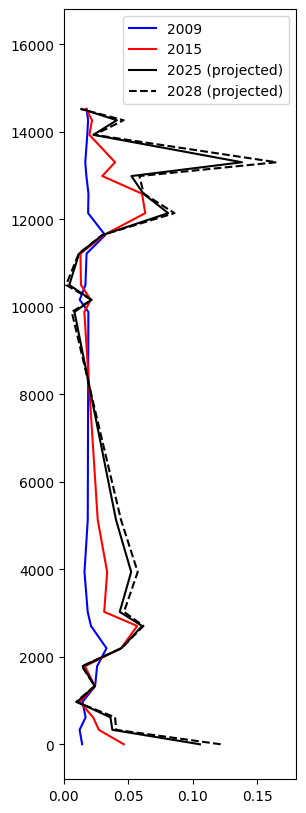

In [1116]:
fig = plt.figure(figsize=(3,10))
plt.plot(grad09[::-1], dists, c="blue", label="2009")
plt.plot(grad16[::-1], dists, c="red", label="2015")
plt.plot(grad25[::-1], dists, c='black', label="2025 (projected)")
plt.plot(grad28[::-1], dists, c='black', linestyle="--", label="2028 (projected)")
plt.scatter([0], 16000, c="white")
plt.legend()
plt.xlim(0, 0.18)